In [82]:
from support_vector_util import *

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import sklearn.metrics as metrics

import pandas as pd
import seaborn as sns
import numpy as np
import pickle

In [12]:
train = pd.read_csv('../data/train.csv')
dev = pd.read_csv('../data/dev.csv')

In [9]:
tp = TextPreprocessor()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dorian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dorian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dorian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
train['processed_text'] = train['text'].apply(tp.preprocess_text)
dev['processed_text'] = dev['text'].apply(tp.preprocess_text)

In [16]:
encoder = Word2VecEncoder(train['processed_text'])

In [21]:
X_train = train['processed_text']
y_train = train['is_humor']

X_dev = dev['processed_text']
y_dev = dev['is_humor']

In [63]:
start_c = 0.25
start_gamma = 0.25

c_params = []
gamma_params = []
f1_scores = []

f1_best = 0
c_best = 0
gamma_best = 0
pipeline_best = None

iterations = 7

for i in range(iterations):
    c = start_c * 2 ** i
    for j in range(iterations):
        gamma = start_gamma * 2 ** j

        model = SVC(class_weight='balanced', C=c, gamma=gamma)
        model_pipeline = Pipeline([
            ('encoder', FunctionTransformer(lambda x: encoder.encode(x, 100))),
            ('svc', model)
        ])

        model_pipeline.fit(X_train, y_train)
        y_pred = model_pipeline.predict(X_dev)
        weighted_f1 = metrics.f1_score(y_dev, y_pred, average='weighted')
        if weighted_f1 > f1_best:
            f1_best = weighted_f1
            c_best = c
            gamma_best = gamma
            pipeline_best = model_pipeline

        gamma_params.append(gamma)
        c_params.append(c)
        f1_scores.append(weighted_f1)

<Axes: >

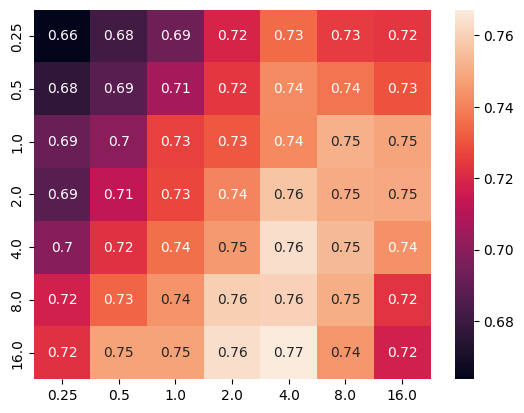

In [59]:
sns.heatmap(np.array(f1_scores).reshape(iterations, iterations),
            annot=True,
            xticklabels=[start_gamma * 2 ** i for i in range(iterations)],
            yticklabels=[start_c * 2 ** i for i in range(iterations)])

# Evaluation

In [65]:
test = pd.read_csv('../data/test.csv')

In [66]:
X_test = test['text'].apply(tp.preprocess_text)
y_test = test['is_humor']

In [67]:
y_pred = pipeline_best.predict(X_test)

In [75]:
print(f1_best)
print(metrics.classification_report(y_dev, y_pred))

0.7672182568160807
              precision    recall  f1-score   support

           0       0.41      0.45      0.43       307
           1       0.63      0.59      0.61       493

    accuracy                           0.54       800
   macro avg       0.52      0.52      0.52       800
weighted avg       0.55      0.54      0.54       800


In [74]:
print(metrics.confusion_matrix(y_dev, y_pred))

[[138 169]
 [200 293]]


# Persistance

In [85]:
model = pipeline_best.steps[1][1]

pickle.dump(model, open('model.pkl', 'wb'))

# Demo

In [102]:
sentence = "I am so funny. Am I?"
pipeline_best.predict([tp.preprocess_text(sentence)])

array([1])

In [100]:
sentence = "This is so sad"
pipeline_best.predict([tp.preprocess_text(sentence)])

array([0])

In [101]:
sentence = "Zagreb is the capital of Croatia."
pipeline_best.predict([tp.preprocess_text(sentence)])

array([1])